In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [22]:
# Plot the relevent outputs used downstream.
# input_obj: for type 1, input odeint output. for type 2, just look at the code to figure out input... 
# plot_type: 1 for concentration plots, 2 for EE steady state plots

def plotter(input_obj, plot_type):
    if plot_type == 1:
        EE = input_obj[:, 0]
        MD = input_obj[:, 1]
        RP = input_obj[:, 2]

        plt.plot()
        plt.title('Concentrations Plot')
        plt.xlabel('Time (hrs)')
        plt.ylabel('Concentration (nM/mL)')
        plt.plot(t, EE, label="EE")
        plt.plot(t, MD, label="MD")
        plt.plot(t, RP, label="RP")
        plt.legend()
        plt.show()

    if plot_type == 2:
        plt.plot(input_obj[0][0], input_obj[0][1], label="EE On")
        plt.plot(input_obj[1][0], input_obj[1][1], label="EE Off")
        plt.legend(loc="best")
        plt.ylabel("EE_SS")
        plt.xlabel("log10 [S]")
        plt.show()

In [3]:
# Dealing with more complex, time-dependent serum concentration behavior

def serum(time):
    R = 7
    hi = 20
    low = .3
    if time < R:
        return hi
    else: return low

In [4]:
# Positive Michaelis-Menten equation
# state: 0 or 1 depending on if a model component will be on or off
# a_or_m: return additive or multiplicative identity when model component is off

def mm_pos(A_n, K_n, n_n, a_or_m, state):
    if state == 0:
        if a_or_m == "a":
            return 0
        if a_or_m == "m":
            return 1
        
    else:
        if A_n < 0:
            A_n = 0
        # Unsure about applying maximum
        if A_n >= 11:
            A_n = 11
            
        val = A_n**n_n/(K_n**n_n + A_n**n_n)
        return val

In [5]:
# Negative Michaelis-Menten equation
# state: 0 or 1 depending on if a model component will be on or off
# a_or_m: return additive or multiplicative identity when model component is off

def mm_neg(A_n, K_n, n_n, a_or_m, state):
    if state == 0:
        if a_or_m == "a":
            return 0
        if a_or_m == "m":
            return 1
        
    else:
        if A_n < 0:
            A_n = 0
        # Unsure about applying maximum
        if A_n >= 11:
            A_n = 11

        val = K_n**n_n/(K_n**n_n + A_n**n_n)
        return val

In [6]:
# For the special 9th model component link
# state7: link 7 on or off
# state9: link 9 on or off

def link_9(state7, state9, MD, EE, n_7, n_9, K_7, K_9, beta_EE=None):
    if state9 == 0:
        link7 = mm_pos(MD, K_7, n_7, "m", state7)
        return link7
    
    if state9 == 1:
        link9a = mm_pos(MD, K_7, n_7, "m", state7) * mm_pos(EE, K_9, n_9, "m", 1)
        return link9a
    
    if state9 == 2:
        link9b = mm_pos(MD, K_7, n_7, "", state7) + beta_EE*mm_pos(EE, K_9, n_9, "a", 1)
        return link9b

In [15]:
# Performs analysis on switch/bistability behavior.
# Need to implement resettability condition in the future.
# EE_SS_on, EE_SS_off: proliferative and quiescent odeint outputs, respectively.

def cond_analysis(EE_SS_on, EE_SS_off):
    # Calculate difference between max and min of SS for EE-off initial condition
    EE_min_max = max(EE_SS_off) - min(EE_SS_off)

    # Switch conditions
    switch = False
    if EE_min_max > lmda:
        switch = True

    # Keep record of delta EE_SS
    delta_EE_SS = []
    for SS_off, SS_on in zip(EE_SS_off, EE_SS_on):
        delta_EE_SS.append(SS_off - SS_on)
        
    # Bistability conditions
    bistable_bool = 0
    if sum([i > EE_min_max * .1 for i in delta_EE_SS]) >= 2 and switch:
        bistable_bool = 1
    elif sum([i > EE_min_max * .2 for i in delta_EE_SS]) >= 1 and switch:
        bistable_bool = 1
    
    return bistable_bool

In [42]:
# Input function for odeint
# Includes logic for upper bound being 11
# Logic for lower bound being 0 should/needs to be implemented

def systems(X, t, S, states):
    EE = X[0]
    MD = X[1]
    RP = X[2]


    dEEdt = (1/tau_EE) * (link_9(states[5], states[7], MD, EE, n_7, n_9, K_7, K_9, beta_EE) * mm_neg(RP, K_6, n_6, "m", states[4]) * mm_neg(MD, K_8, n_8, "m", states[6]) * mm_neg(EE, K_10, n_10, "m", states[8]) - EE)
    dMDdt = (1/tau_MD) * (mm_pos(S, K_1, n_1, "m", 1) + beta_MD*mm_pos(EE, K_2, n_2, "a", states[0]) - MD)
    dRPdt = (1/tau_RP) * ((1 + beta_RP*mm_pos(EE, K_4, n_4, "a", states[2])) * mm_neg(MD, K_3, n_3, "m", states[1]) * mm_neg(EE, K_5, n_5, "m", states[3]) - RP)
    
    return [dEEdt, dMDdt, dRPdt]

## Loading parameters, states, initial conditions, time steps, and serum concentration

In [50]:
# Load parameters
params = pd.read_csv("parameters.csv")

# Initial conditions
X0_on = [11, 11, 0.01] # EE-on initial condition
X0_off = [.01, .01, 11] # EE-off initial condition

# Time steps
t = np.linspace(.2, 200, 100)

# .01 to 20 serum concentration
serum_con = np.logspace(-2, 1.3, 25)

# On/off components of model
# link 9: 0 for off, 1 for 9a, 2 for 9b
# Most robust: states = [1, 1, 0, 1, 1, 1, 0, 2, 0]
# Links:  2  3  4  5  6  7  8  9  10
states = [1, 1, 0, 1, 1, 1, 0, 2, 0]

# For switch and bistability
lmda = .1

## Generating Time x Concentration graphs for 1 $[S]$ value

In [ ]:
# Initialize dictionary to store final steady-state concentrations
steady_states = {
    "EE": [],
    "MD": [],
    "RP": []
}

S = 10

# Loop through parameters and record steady-state concentrations
for i in range(params.shape[0]-19900):
    # Update parameters from row of df
    globals().update(params.iloc[i].to_dict())

    # Calculate ODEs
    sol = odeint(systems, X0_on, t, args=(S, states))
    
    # Record steady-state concentrations
    steady_states["EE"].append(sol[-1, 0])
    steady_states["MD"].append(sol[-1, 1])
    steady_states["RP"].append(sol[-1, 2])
    
    plotter(sol,1)

## Generating $[S]$ x $EE_{SS}$ graphs and analyzing for bistability

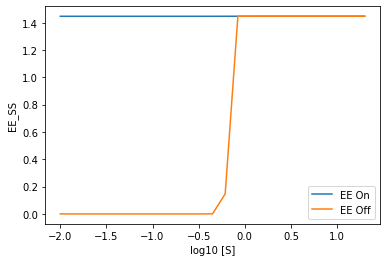

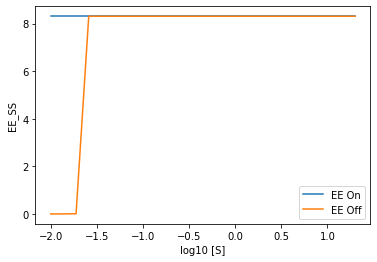

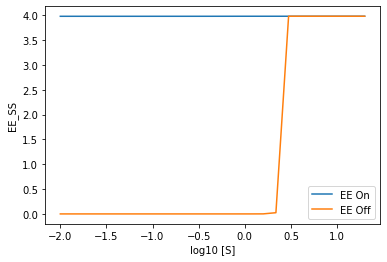

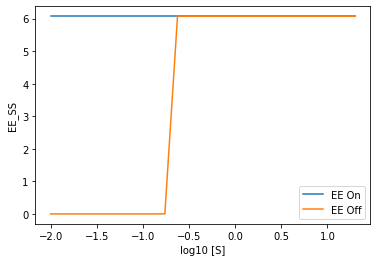

KeyboardInterrupt: 

In [51]:
# Initialize dictionary to store final steady-state concentrations
steady_states = {
    "EE": [],
    "MD": [],
    "RP": []
}

# Counters for switch and bistability
switch_count = 0
bistable_count = 0

# Loop through parameters and record steady-state concentrations
for i in range(params.shape[0]):
    # Update parameters from row of df
    globals().update(params.iloc[i].to_dict())
    
    EE_SS_on = []
    EE_SS_off = []

    for S in serum_con:
        # Calculate ODEs
        psol = odeint(systems, X0_on, t, args=(S, states))
        qsol = odeint(systems, X0_off, t, args=(S, states))
        
        # Per-parameter-set steady state recording
        EE_SS_on.append(psol[-1, 0])
        EE_SS_off.append(qsol[-1, 0])

    bistable_count += cond_analysis(EE_SS_on, EE_SS_off)

    # Bistability status printer
    print(f"{bistable_count}/{i + 1} bistable.", end="\r")
    
    # Plot EE steady state with log10 serum concentration
    plot_obj = [(np.log10(serum_con), EE_SS_on), (np.log10(serum_con), EE_SS_off)]
    plotter(plot_obj, 2)

In [ ]:
x = [.01, .02, .5, .25, .1, -.01, -.5]
x = 1.2
x_dot = -.5

x_dot[(x <= 0) * (x_dot <= 0)]=0.0